### Basic Dependencies

#### Linear

Given task only executes when upstream dependencies have finished executing successfully.

* Clear order

In [ ]:
taskA >> taskB >> taskC

#### Fan-in/out dependencies


In [ ]:
from airflow.operators.dummy import DummyOperator

start = DummyOperator(task_id="start") #dummy start task
 
start >> [fetch_weather, fetch_sales] #fan-out (one-to-multiple) dependency

In [ ]:
[task_A,task_B] >> task_C #fan-in
task_C >> task >> D

### Branching within tasks

Callables passed to the <b>_BranchPython-Operator_</b> are expected to return the ID of a downstream task as a result of their computation. The returned ID determines which of the downstream tasks will be executed after completion of the branch task.

In [ ]:
def _pick_erp_system(**context):
    if context["execution_date"] < ERP_SWITCH_DATE:
        return "fetch_sales_old"
    else:
        return "fetch_sales_new"
    

pick_erp_system = BranchPythonOperator(
    task_id="pick_erp_system",
    python_callable=_pick_erp_system,
)


start >> pick_erp_system >> [fetch_sales_old, fetch_sales_new]

This behavior that defines when tasks are executed is controlled by so-called <b>trigger rules</b> in Airflow. Trigger rules can be defined for individual tasks using the <b>_trigger \_rule_</b> argument, which can be passed to any operator. By default, trigger rules are set to all_success, meaning that all parents of the corresponding task need to succeed before the task can be run.

<div>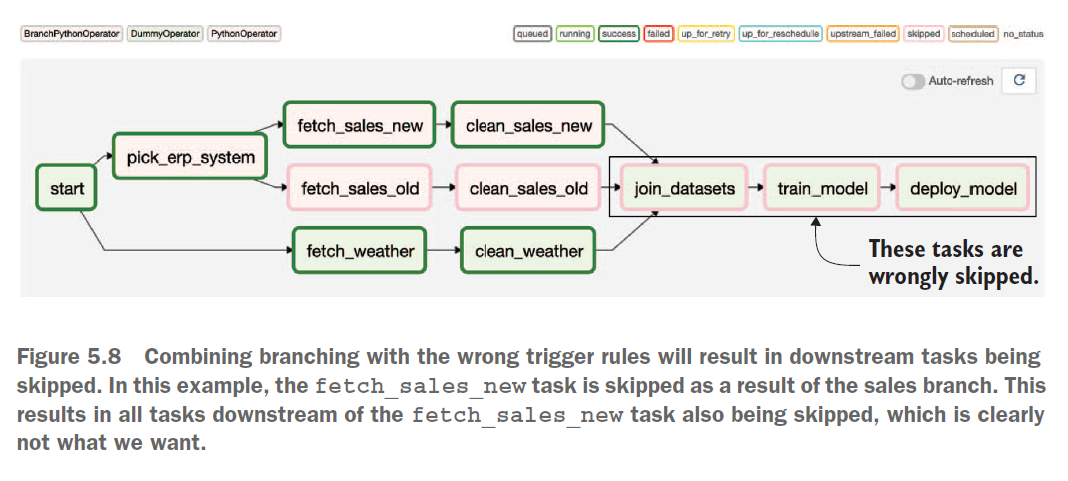</div>

In [ ]:
join_datasets = PythonOperator(
    ..., ## joining operation..
    trigger_rule="none_failed",
)

### Trigger Rules

Trigger rules are essentially the conditions that Airflow applies to tasks to determine whether they are ready to execute, as a function of their dependencies. 

Airflow’s default trigger rule is <b>_all_success_</b>

_propagation_: result of upstream tasks affecting downstream tasks.

### Sharing data between tasks

tasks share small pieces of data between them using XComs (cross communication).

In [ ]:
## Pushes model id
def _train_model(**context):
    model_id = str(uuid.uuid4())
    context["task_instance"].xcom_push(key="model_id", value=model_id)
    
train_model = PythonOperator(
    task_id="train_model",
    python_callable=_train_model,
)

## Pulls model id

def _deploy_model(**context):
    model_id = context["task_instance"].xcom_pull(
        task_ids="train_model", key="model_id"
    )
    
    print(f"Deploying model {model_id}")

deploy_model = PythonOperator(
    task_id="deploy_model",
    python_callable=_deploy_model,
)

#### Drawback of XComs

Hidden dependencies  between tasks: they are not visible in the DAG and will not be taken into account when scheduling the tasks &rarr; Airflow won't make sure the XCom dependencies are executed in the correct order.